In [1]:
import numpy as np
import typing as tp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import sys
import os
import time
import random

In [2]:
from BaselineSolver import BaselineSolver
from IterativeSolver import IterativeSolver
from GreedySolver import GreedySolver
from utils import run_tests, read_tests_simplex_in_ball, run_random_test, spherical_cap_crosslike_grid

In [3]:
spherical_cap_crosslike_grid(center=np.array([-1,0]), cross_radius=0.01, random_rotation_pool=np.array([[1]]))

array([[-0.99995  ,  0.0099995],
       [-0.99995  , -0.0099995],
       [-1.       ,  0.       ]])

In [4]:
%load_ext line_profiler

In [5]:
def get_baseline_test_results(dimension: int, number_tests: int, lowest_grid_density: float=100, highest_grid_density: float=10000,
                             silent=True) -> tp.Tuple[np.ndarray, np.ndarray]:
    times = []
    t_errors = []
    for _ in range(number_tests):
        time, t_error = run_random_test(BaselineSolver, dimension, 
                                        {'grid_density': np.exp(np.random.uniform(np.log(lowest_grid_density), np.log(highest_grid_density)))}, 
                                        read_tests_simplex_in_ball, f'./tests/{dimension}d/simplex-in-ball/', silent=silent)
        times.append(time)
        t_errors.append(t_error)
    
    return np.array(times), np.array(t_errors)

In [6]:
def get_iterative_test_results(dimension: int, number_tests: int, lowest_cap_grid_diameter: int=3, 
                               highest_cap_grid_diameter: int=10,
                              silent=True) -> tp.Tuple[np.ndarray, np.ndarray]:
    times = []
    t_errors = []
    for _ in range(number_tests):
        cap_grid_diameter = int(np.round(np.exp(np.random.uniform(np.log(lowest_cap_grid_diameter), np.log(highest_cap_grid_diameter)))))
        time, t_error = run_random_test(IterativeSolver, dimension, 
                                        {'cap_grid_diameter': cap_grid_diameter}, 
                                        read_tests_simplex_in_ball, f'./tests/{dimension}d/simplex-in-ball/', silent=silent)
        times.append(time)
        t_errors.append(t_error)
    
    return np.array(times), np.array(t_errors)

In [7]:
def get_greedy_test_results(dimension: int, lowest_max_iteration: int=500, highest_max_iteration: int=1000, 
                            silent=True) -> tp.Tuple[np.ndarray, np.ndarray]:
    times = []
    t_errors = []
    deltas = []
    for file in sorted(os.listdir(f'./tests/{dimension}d/simplex-in-ball/')):
        support_a, support_b, delta = read_tests_simplex_in_ball(f'./tests/{dimension}d/simplex-in-ball/{file}', dimension)
        solver_instance = GreedySolver(dimension, support_a, support_b, 
                                 num_iterations=int(np.exp(np.random.uniform(np.log(lowest_max_iteration), np.log(highest_max_iteration)))))
        start_time = time.time()
        solver_instance.solve()
        end_time = time.time()
        times.append(end_time - start_time)
        t_errors.append(abs(1. - solver_instance.t))
        deltas.append(delta)
        if not silent:
            print(f'test \t{file}\t time \t{end_time - start_time}\t t_error \t{abs(1. - solver_instance.t)}')

    return np.array(times), np.array(t_errors), np.array(deltas)

In [8]:
def plot_test_results(times: np.ndarray, t_errors: np.ndarray, deltas: np.ndarray, title: str, fit=True) -> None:
    t_errors_without_zeros = np.copy(t_errors)
    t_errors_without_zeros[t_errors_without_zeros == 0.] = 1e-16
    
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111)
    plt.xlabel('time, s')
    plt.ylabel('t_error')
    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.scatter(times, t_errors_without_zeros, c=deltas, cmap='viridis_r', norm=LogNorm())
    plt.colorbar(label='delta')
    if fit:
        a, b = np.polyfit(np.log(times), np.log(t_errors_without_zeros), 1)
        plt.plot(times, np.exp(a * np.log(times) + b), 'r', label=f't_error ~ 1 / time^{-a:.2f}')
        plt.legend()
    plt.title(title)
    plt.savefig(f'figures/{title.replace(" ", "_").replace(",", "")}')

In [16]:
file = random.choice(os.listdir('./tests/10d/simplex-in-ball/'))
support_a, support_b, delta = read_tests_simplex_in_ball(f'./tests/10d/simplex-in-ball/{file}', 10)
solver_instance = GreedySolver(10, support_a, support_b, num_iterations=500)

In [17]:
%prun solver_instance.solve()

         4179480 function calls (4005191 primitive calls) in 11.016 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      501    3.931    0.008    3.931    0.008 {scipy.optimize._highs.cython.src._highs_wrapper._highs_wrapper}
    27944    1.416    0.000    5.316    0.000 utils.py:223(spherical_cap_crosslike_grid)
445537/272250    0.865    0.000    2.983    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
    88012    0.476    0.000    0.891    0.000 linalg.py:2342(norm)
    27954    0.280    0.000    0.280    0.000 {method 'randint' of 'numpy.random.mtrand.RandomState' objects}
      500    0.275    0.001    0.440    0.001 GreedySolver.py:31(extract_new_based_vectors)
    55890    0.241    0.000    0.309    0.000 twodim_base.py:162(eye)
    27944    0.227    0.000    0.253    0.000 numeric.py:858(outer)
    40221    0.223    0.000    0.223    0.000 {method 'reduce' of 'numpy.ufunc' objects}
   

test 	1	 time 	0.4958937168121338	 t_error 	0.0
test 	10	 time 	0.7196981906890869	 t_error 	2.220446049250313e-16
test 	100	 time 	0.5559673309326172	 t_error 	4.440892098500626e-16
test 	11	 time 	0.8527359962463379	 t_error 	2.220446049250313e-16
test 	12	 time 	0.688988447189331	 t_error 	2.220446049250313e-16
test 	13	 time 	0.5294792652130127	 t_error 	2.220446049250313e-16
test 	14	 time 	0.7436742782592773	 t_error 	2.220446049250313e-16
test 	15	 time 	0.8583812713623047	 t_error 	2.220446049250313e-16
test 	16	 time 	0.7096304893493652	 t_error 	2.220446049250313e-16
test 	17	 time 	0.6004083156585693	 t_error 	2.220446049250313e-16
test 	18	 time 	0.6510539054870605	 t_error 	2.220446049250313e-16
test 	19	 time 	0.833885908126831	 t_error 	2.220446049250313e-16
test 	2	 time 	0.930321455001831	 t_error 	2.220446049250313e-16
test 	20	 time 	0.6359512805938721	 t_error 	2.220446049250313e-16
test 	21	 time 	0.689378023147583	 t_error 	2.220446049250313e-16
test 	22	 time 	0.

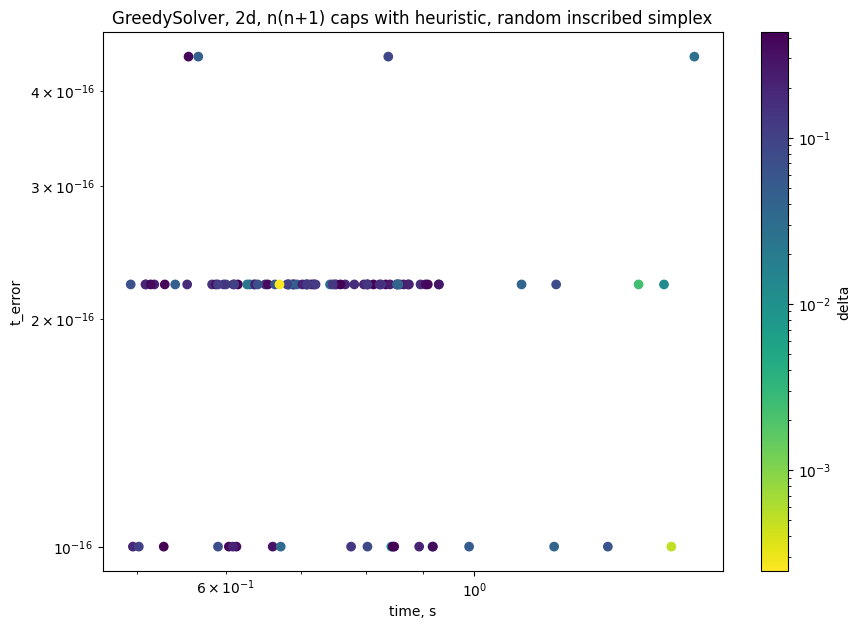

In [11]:
times_greedy_2d, errors_greedy_2d, deltas_greedy_2d = get_greedy_test_results(2, silent=False)
plot_test_results(times_greedy_2d, errors_greedy_2d, deltas_greedy_2d, 'GreedySolver, 2d, n(n+1) caps with heuristic, random inscribed simplex', fit=False)

test 	1	 time 	0.8185844421386719	 t_error 	2.220446049250313e-16
test 	10	 time 	1.9308147430419922	 t_error 	0.0
test 	100	 time 	1.3322429656982422	 t_error 	2.220446049250313e-16
test 	11	 time 	1.1895098686218262	 t_error 	0.0
test 	12	 time 	0.7479672431945801	 t_error 	4.440892098500626e-16
test 	13	 time 	0.8524796962738037	 t_error 	2.220446049250313e-16
test 	14	 time 	1.8438076972961426	 t_error 	2.220446049250313e-16
test 	15	 time 	0.9386203289031982	 t_error 	2.220446049250313e-16
test 	16	 time 	1.4891483783721924	 t_error 	1.3322676295501878e-15
test 	17	 time 	0.7084650993347168	 t_error 	2.220446049250313e-16
test 	18	 time 	0.813460111618042	 t_error 	2.220446049250313e-16
test 	19	 time 	1.3729631900787354	 t_error 	0.0
test 	2	 time 	0.9988541603088379	 t_error 	2.220446049250313e-16
test 	20	 time 	1.1977438926696777	 t_error 	2.220446049250313e-16
test 	21	 time 	0.7037835121154785	 t_error 	0.0
test 	22	 time 	0.8669238090515137	 t_error 	4.440892098500626e-16
t

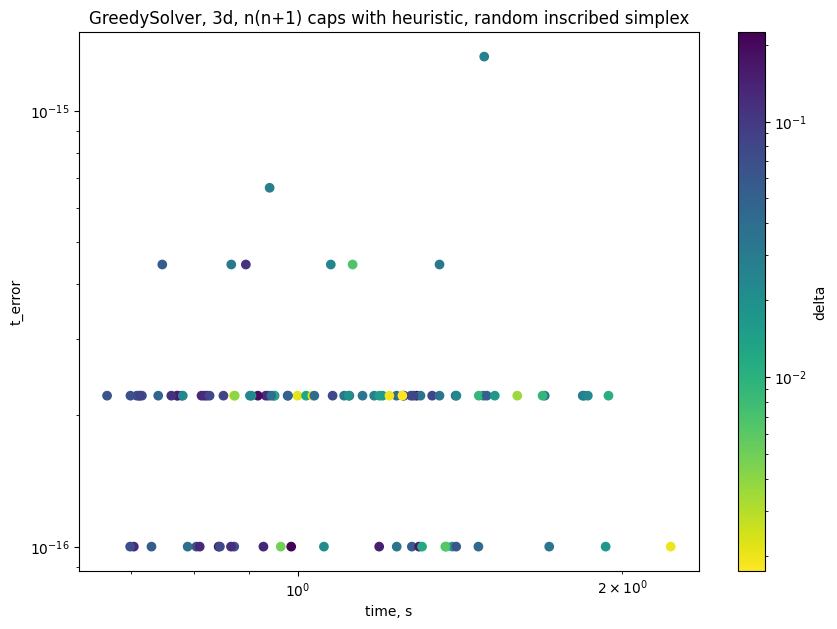

In [12]:
times_greedy_3d, errors_greedy_3d, deltas_greedy_3d = get_greedy_test_results(3, silent=False)
plot_test_results(times_greedy_3d, errors_greedy_3d, deltas_greedy_3d, 'GreedySolver, 3d, n(n+1) caps with heuristic, random inscribed simplex', fit=False)

test 	1	 time 	0.944765567779541	 t_error 	2.220446049250313e-16
test 	10	 time 	1.309058427810669	 t_error 	2.220446049250313e-16
test 	100	 time 	0.9540841579437256	 t_error 	0.0
test 	11	 time 	1.7476675510406494	 t_error 	2.220446049250313e-16
test 	12	 time 	1.7846412658691406	 t_error 	2.220446049250313e-16
test 	13	 time 	1.6866939067840576	 t_error 	4.440892098500626e-16
test 	14	 time 	0.9713902473449707	 t_error 	2.220446049250313e-16
test 	15	 time 	0.9275085926055908	 t_error 	2.220446049250313e-16
test 	16	 time 	1.7052819728851318	 t_error 	2.220446049250313e-16
test 	17	 time 	1.2345092296600342	 t_error 	2.220446049250313e-16
test 	18	 time 	1.2852451801300049	 t_error 	2.220446049250313e-16
test 	19	 time 	1.2385506629943848	 t_error 	2.220446049250313e-16
test 	2	 time 	1.7864315509796143	 t_error 	2.220446049250313e-16
test 	20	 time 	1.6726267337799072	 t_error 	2.220446049250313e-16
test 	21	 time 	1.17915940284729	 t_error 	4.440892098500626e-16
test 	22	 time 	0.

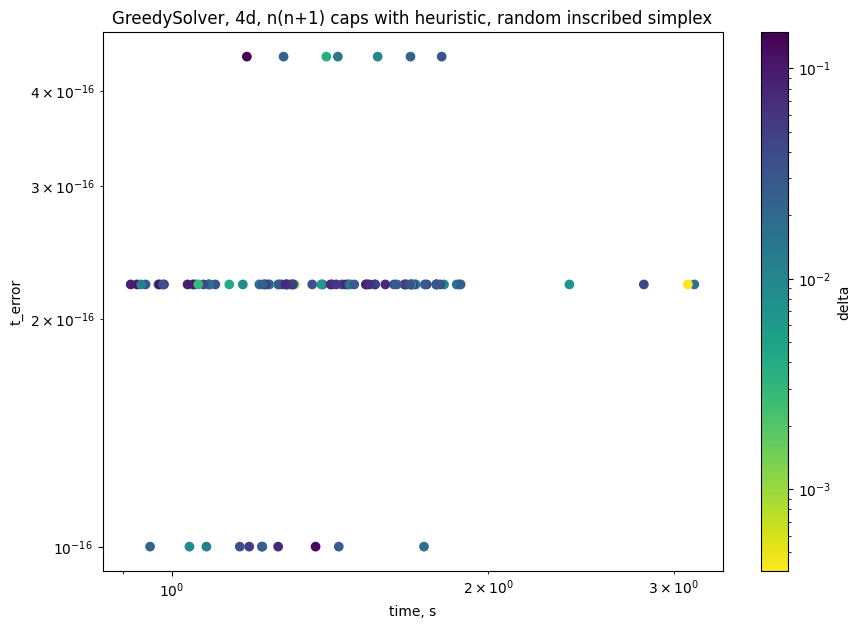

In [13]:
times_greedy_4d, errors_greedy_4d, deltas_greedy_4d = get_greedy_test_results(4, silent=False)
plot_test_results(times_greedy_4d, errors_greedy_4d, deltas_greedy_4d, 'GreedySolver, 4d, n(n+1) caps with heuristic, random inscribed simplex', fit=False)

test 	1	 time 	2.228794574737549	 t_error 	2.220446049250313e-16
test 	10	 time 	1.410681962966919	 t_error 	2.220446049250313e-16
test 	100	 time 	1.3703522682189941	 t_error 	2.220446049250313e-16
test 	11	 time 	1.8715238571166992	 t_error 	2.220446049250313e-16
test 	12	 time 	1.9250884056091309	 t_error 	0.0
test 	13	 time 	1.829530954360962	 t_error 	2.220446049250313e-16
test 	14	 time 	1.9137635231018066	 t_error 	0.0
test 	15	 time 	1.415029764175415	 t_error 	0.0
test 	16	 time 	1.357353687286377	 t_error 	0.0
test 	17	 time 	1.9518685340881348	 t_error 	2.220446049250313e-16
test 	18	 time 	2.2813854217529297	 t_error 	4.440892098500626e-16
test 	19	 time 	2.1337835788726807	 t_error 	2.220446049250313e-16
test 	2	 time 	1.3257009983062744	 t_error 	2.220446049250313e-16
test 	20	 time 	1.3057870864868164	 t_error 	2.220446049250313e-16
test 	21	 time 	1.4587907791137695	 t_error 	2.220446049250313e-16
test 	22	 time 	1.7583472728729248	 t_error 	2.220446049250313e-16
test 	

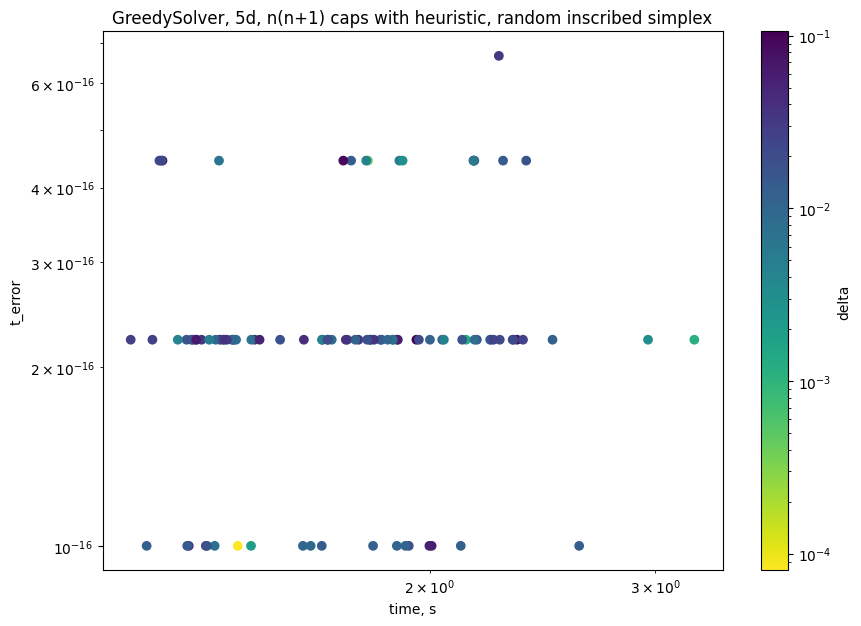

In [14]:
times_greedy_5d, errors_greedy_5d, deltas_greedy_5d = get_greedy_test_results(5, silent=False)
plot_test_results(times_greedy_5d, errors_greedy_5d, deltas_greedy_5d, 'GreedySolver, 5d, n(n+1) caps with heuristic, random inscribed simplex', fit=False)

test 	1	 time 	17.572081565856934	 t_error 	2.220446049250313e-16
test 	10	 time 	10.04386305809021	 t_error 	2.220446049250313e-16
test 	100	 time 	9.848610162734985	 t_error 	2.220446049250313e-16
test 	11	 time 	14.574097633361816	 t_error 	4.440892098500626e-16
test 	12	 time 	16.757885694503784	 t_error 	4.440892098500626e-16
test 	13	 time 	18.01181721687317	 t_error 	2.220446049250313e-16
test 	14	 time 	10.490190744400024	 t_error 	6.661338147750939e-16
test 	15	 time 	10.809364795684814	 t_error 	2.220446049250313e-16
test 	16	 time 	18.667616367340088	 t_error 	2.220446049250313e-16
test 	17	 time 	11.95464825630188	 t_error 	4.440892098500626e-16
test 	18	 time 	17.292057752609253	 t_error 	2.220446049250313e-16
test 	19	 time 	13.390276193618774	 t_error 	2.220446049250313e-16
test 	2	 time 	12.322598218917847	 t_error 	0.0
test 	20	 time 	33.62749743461609	 t_error 	4.440892098500626e-16
test 	21	 time 	17.532904148101807	 t_error 	2.220446049250313e-16
test 	22	 time 	9.8

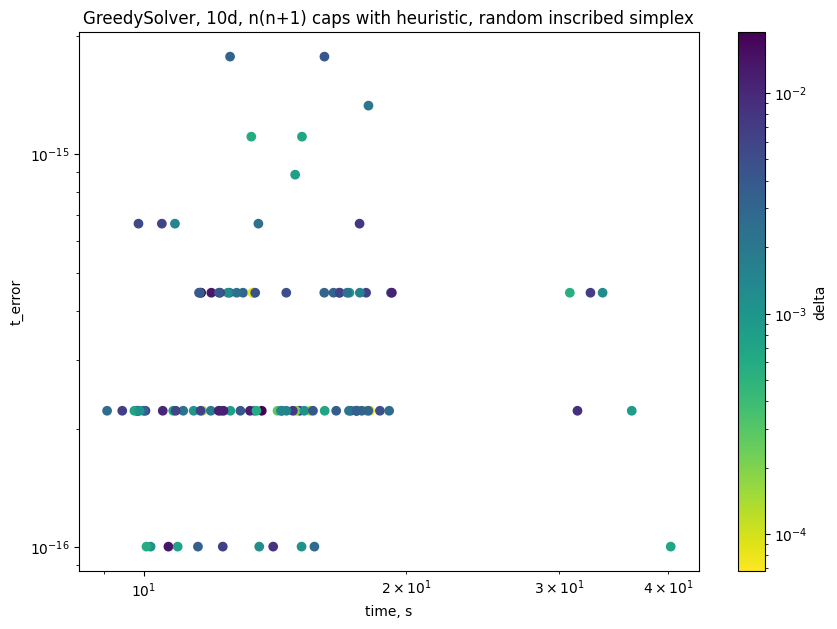

In [15]:
times_greedy_10d, errors_greedy_10d, deltas_greedy_10d = get_greedy_test_results(10, silent=False)
plot_test_results(times_greedy_10d, errors_greedy_10d, deltas_greedy_10d, 'GreedySolver, 10d, n(n+1) caps with heuristic, random inscribed simplex', fit=False)

times_iterative_2d, errors_iterative_2d = get_iterative_test_results(2, 100, silent=True, highest_cap_grid_diameter=3)
plot_test_results(times_iterative_2d, errors_iterative_2d, 'IterativeSolver, 2d, n(n+1) caps with startovers, random inscribed simplex', fit=False)

times_iterative_3d, errors_iterative_3d = get_iterative_test_results(3, 100, silent=True, highest_cap_grid_diameter=3)
plot_test_results(times_iterative_3d, errors_iterative_3d, 'IterativeSolver, 3d, n(n+1) caps with startovers, random inscribed simplex', fit=False)

times_iterative_4d, errors_iterative_4d = get_iterative_test_results(4, 100, silent=True, highest_cap_grid_diameter=3)
plot_test_results(times_iterative_4d, errors_iterative_4d, 'IterativeSolver, 4d, n(n+1) caps with startovers, random inscribed simplex', fit=False)

times_iterative_5d, errors_iterative_5d = get_iterative_test_results(5, 100, silent=True, highest_cap_grid_diameter=3)
plot_test_results(times_iterative_5d, errors_iterative_5d, 'IterativeSolver, 5d, n(n+1) caps with startovers, random inscribed simplex', fit=False)

times_baseline_2d, errors_baseline_2d = get_baseline_test_results(2, 1000)

plot_test_results(times_baseline_2d, errors_baseline_2d, 'BaselineSolver, 2d, grid_from_cube, random inscribed simplex')

times_baseline_3d, errors_baseline_3d = get_baseline_test_results(3, 1000)

plot_test_results(times_baseline_3d, errors_baseline_3d, 'BaselineSolver, 3d, grid_from_cube, random inscribed simplex')

times_baseline_4d, errors_baseline_4d = get_baseline_test_results(4, 1000)

plot_test_results(times_baseline_4d, errors_baseline_4d, 'BaselineSolver, 4d, grid_from_cube, random inscribed simplex')

times_baseline_5d, errors_baseline_5d = get_baseline_test_results(5, 1000)

plot_test_results(times_baseline_5d, errors_baseline_5d, 'BaselineSolver, 5d, grid_from_cube, random inscribed simplex')